# Differential Privacy for Machine Learning

In [27]:
from ipywidgets import interact
from IPython.display import display
import numpy as np
import dp_stats as dps
import pandas as pd
from sklearn import svm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Differentially Private PCA
---

The following tutorial gives one example of how the `dp_pca()` funciton is called. The data samples are randomly drawn i.i.d. from a multivariate Gaussian distribution with a pre-defined mean and covariance matrix. The quality (in terms of the captured energy of the covariance matrix in the reduced dimensional subspace) of the output subspace of the differentially private PCA and non-differentially private PCA is shown as a comparison. 

The parameters that can be adjusted are:

- Epsilon
- Sample_size

In [28]:

# This tutorial gives an example of one way to use the differentially private PCA function
# A non-differentially private version of the PCA process will also be run to generate the likeness of the two


# This function will be used to randomly generate a data matrix from a multivariate Gaussian distribution
def gen_data(Sample_size, k):
    """
    
    
    Parameters
    -----------
    Sample_size: scalar
        total number of test samples to return in data matrix
    k : scalar <10
        number of dimensions with structure
            
    Outputs:
            trn_data: [trn_size x d]
            A: covariance matrix, [d x d]
    """


    d = 10                       # features
    n = Sample_size              # number of samples to generate for each class

    # create covariance matrix
    A = np.zeros((d,d))
    for i in range(d):
        if i < k:
            A[i,i] = d - i
        else:
            A[i, i] = 1

    # create mean
    mean = np.zeros(d)

    # generate n samples
    data_ = np.random.multivariate_normal(mean, A, n)    # [nxd]

    return data_, A

# This function will allow the PCA outputs to be interactive
def show_pca_qual(Sample_size, k = 5, Epsilon = 1.0):

    
    # generate the data matrix
    data_, A = gen_data(Sample_size, k)    # data_: samples are in rows, A: covariance matrix
    
    # go through the non-differentially private PCA routine
    sigma_control = np.dot(data_.T, data_)     # [d x d] = [d x Sample_size] [Sample_size x d]
    U, S, V = np.linalg.svd(sigma_control)
    
    # grab the first k columns
    U_reduc = U[:, :k]
    
    # find the quality of the PCA control
    control_quality = np.trace(np.dot(np.dot(U_reduc.T, A), U_reduc))
    
    
    # go through the differentially private PCA routine
    # dp_pca_sn ( data, epsilon=1.0 )  // samples must be in columns
    sigma_dp = dps.dp_pca_sn(data_.T, epsilon = Epsilon)
    U_dp, S_dp, V_dp = np.linalg.svd(sigma_dp)
    
    # grab the first k columns
    U_dp_reduc = U_dp[:, :k]
    
    # find the quality of the differentially private PCA method
    dp_quality = np.trace(np.dot(np.dot(U_dp_reduc.T, A), U_dp_reduc))
    
    # output the results
    control_txt = "Non-private Quality: {}".format(round(control_quality, 4))
    display(control_txt)
    dp_txt = "Differentially Private Quality: {}".format(round(float(dp_quality), 4))
    display(dp_txt)

interact(show_pca_qual,  k=(1, 10, 1), Sample_size=(50,1000,100), Epsilon=(0.01,3.0,0.01));

interactive(children=(IntSlider(value=450, description='Sample_size', max=1000, min=50, step=100), IntSlider(v…

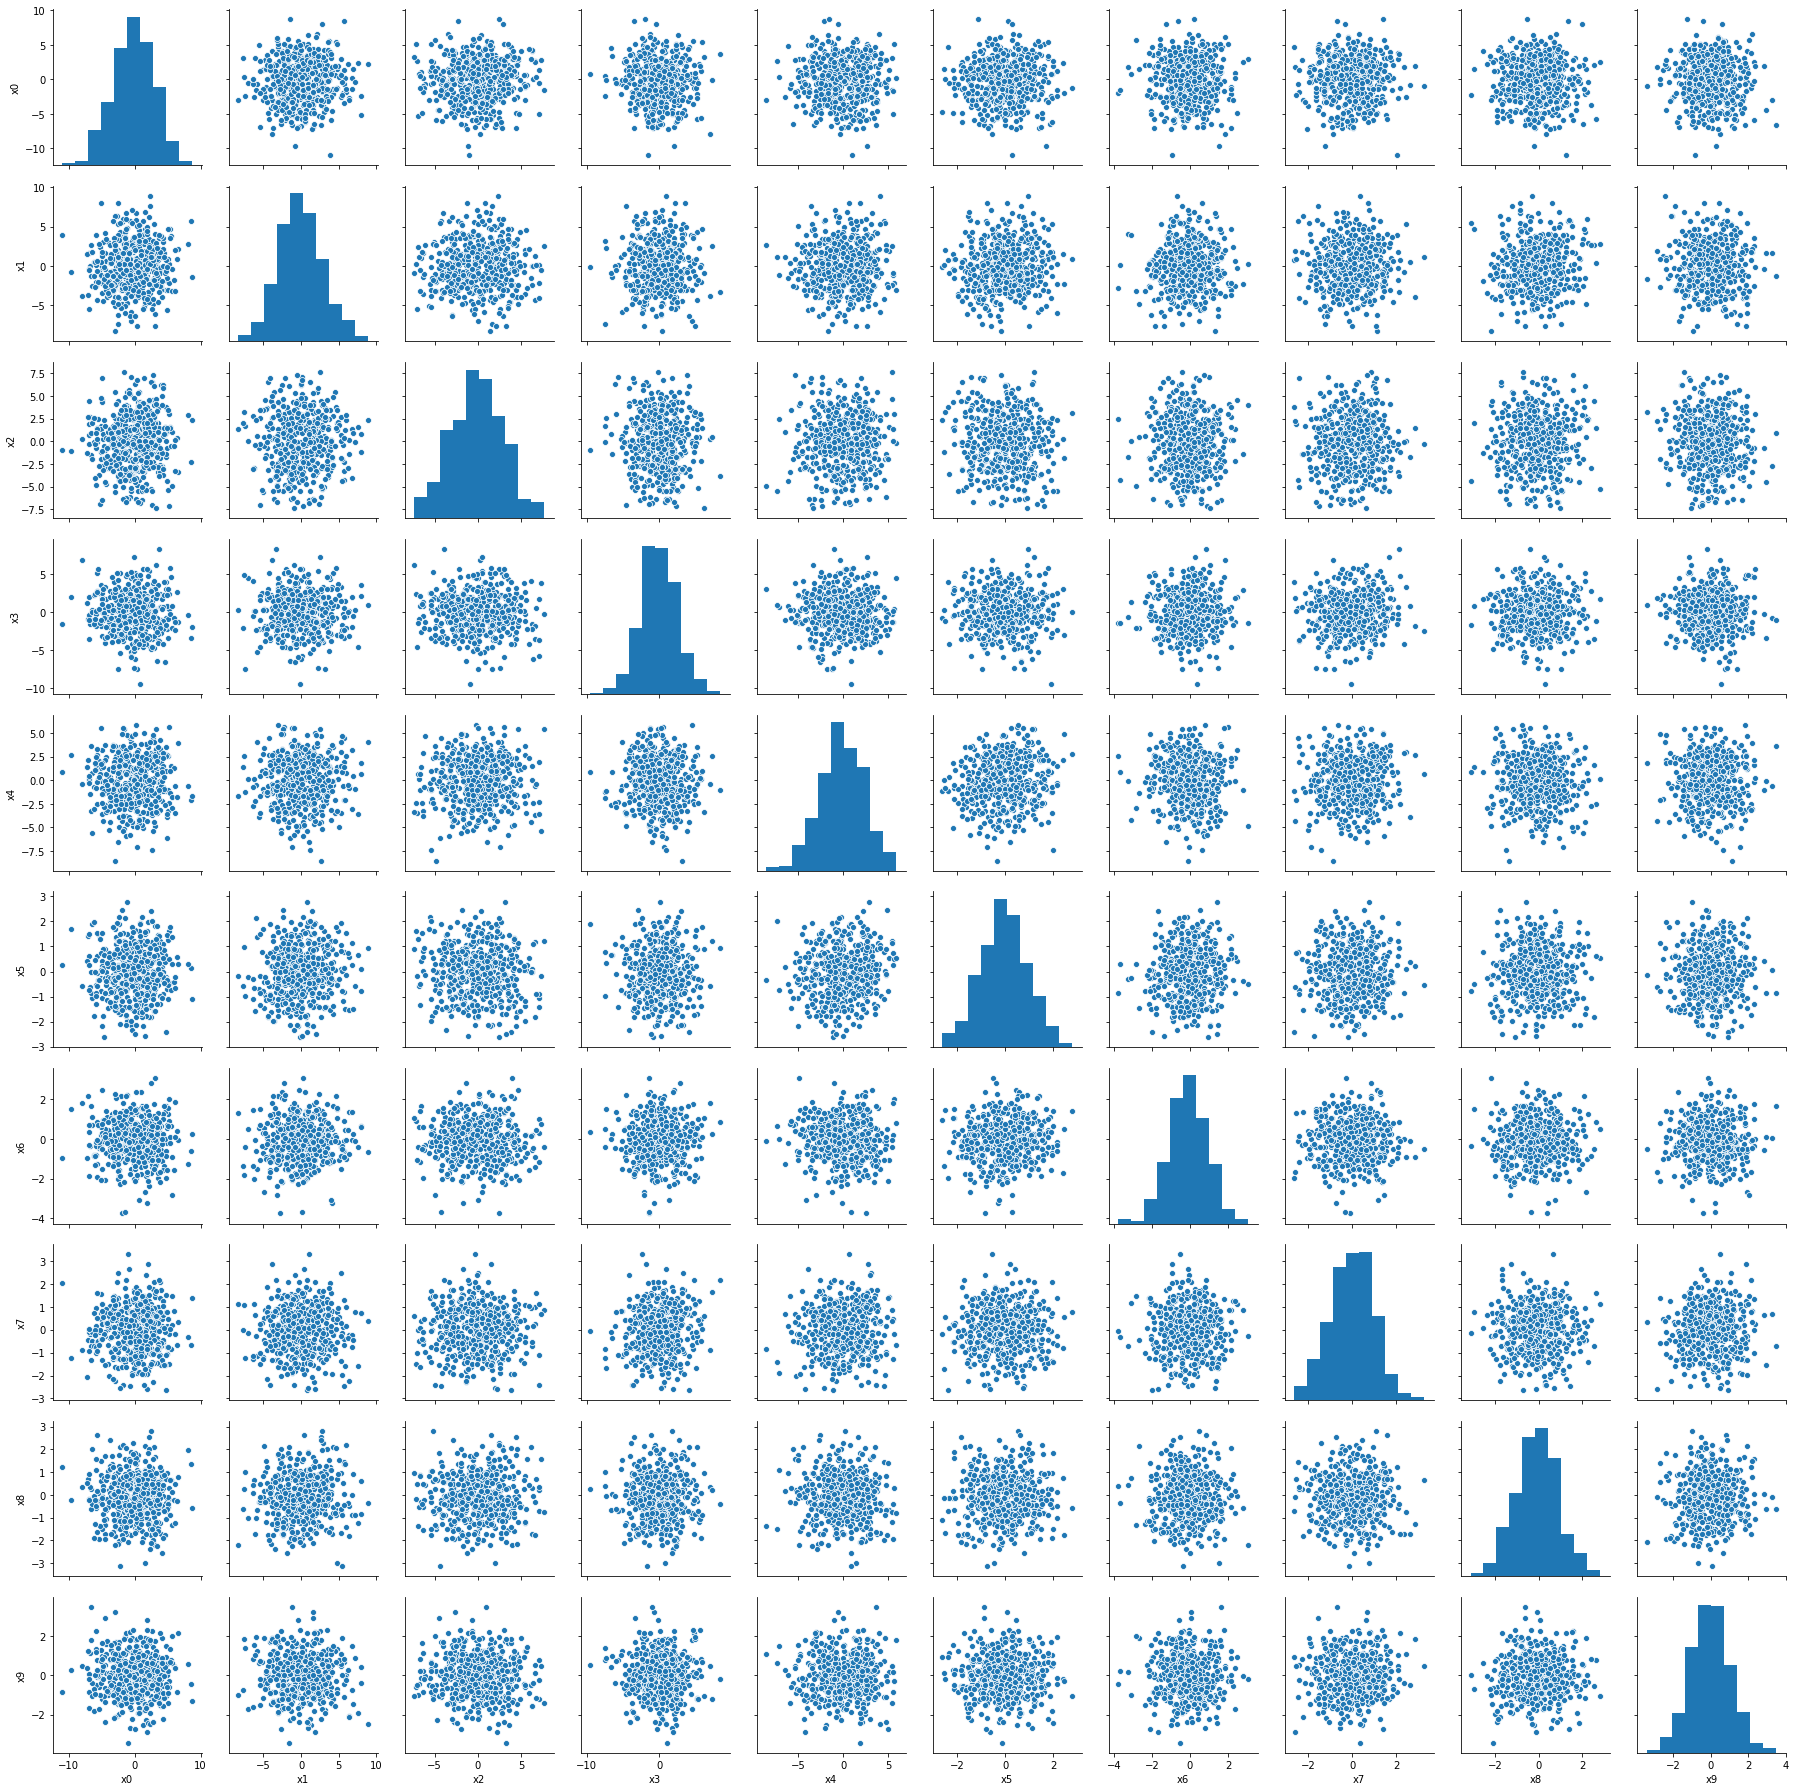

In [29]:
data,A = gen_data(500, 5)
r,c = data.shape
df = pd.DataFrame(data, columns = ['x'+str(i) for i in range(c)])
sns.pairplot(data = df)

## Differentially Private SVM Algorithm Tutorial


The following tutorial gives one example of how a differentially private pipeline of PCA and SVM functions are called. The data set used is generated from randomly drawn samples from a mulitivariate Gaussian distribution. A non-differentially private pipeline of PCA and SVM is also utilized. This is used to compare the results (classification accuracy) of the differentially private pipeline.

###### A sample of the pipeline is shown below:

Generate samples --> Perform PCA for dimension reduction --> Perform SVM for classifier training --> Test classifier

The parameters that can be adjusted are:

- Epsilon_pca
- Epsilon_svm

In [40]:
# This tutorial shows one common pipeline for learning a binary classifier


# This function is used to randomly generate data samples from a multivariate Gaussian distribution.
def gen_data(num_tst_samp, k):
    """
    Inputs:
            num_tst_samp: total number of test samples to return in data matrix
            k: number of samples to generate for each class
    Outputs:
            data: data matrix with samples in rows, [nxd]
            labels: n dimensional vector
    """


    d = 10    # features
    n = num_tst_samp

    # create covariance matrix
    A = np.zeros((d,d))
    for i in range(d):
        if i < k:
            A[i,i] = d - i
        else:
            A[i, i] = 1

    # create mean for class 1
    mean1 = -1 * np.ones(d)

    # create mean for class 2
    mean2 = np.ones(d)

    # generate n samples for class 1
    cls1_samps = np.random.multivariate_normal(mean1, A, n)    # [nxd]
    # generate n samples for class 2
    cls2_samps = np.random.multivariate_normal(mean2, A, n)    # [nxd]
    return cls1_samps, cls2_samps, A

def gen_data2(num_tst_samp, k):
    """
    Inputs:
            num_tst_samp: total number of test samples to return in data matrix
            k: number of samples to generate for each class
    Outputs:
            data: data matrix with samples in rows, [nxd]
            labels: n dimensional vector
    """


    d = 10    # features
    n = num_tst_samp

    # create covariance matrix
    A = np.eye(d)

    # create mean for class 1
    mean1 = [1]*d

    # create mean for class 2
    mean2 = [-1]*d
    mean2[k:] = [1]*(d-k)

    # generate n samples for class 1
    cls1_samps = np.random.multivariate_normal(mean1, A, n)    # [nxd]
    # generate n samples for class 2
    cls2_samps = np.random.multivariate_normal(mean2, A, n)    # [nxd]
    return cls1_samps, cls2_samps, A

In [49]:
# This function is used to randomly mix the two class samples and return training and testing data
def sample_selection(data_cls1, data_cls2, trn_size):
    """
    Inputs:
            data_cls1: class 1 data, samples are in rows [nxd]
            data_cls2: class 2 data, samples are in rows [nxd]
            trn_size: number of samples to use for training data, integer
            tst_size: number of samples to use for testing data, integer
    Outputs:
            trn_data: [trn_size x d]
            trn_labels:[trn_size]
            tst_data: [tst_size x d]
            tst_labels: [tst_size]
    """

    N = len(data_cls1)
    ind = np.random.permutation(N)
    trn_data1 = data_cls1[ind[:trn_size],:]
    trn_data2 = data_cls2[ind[:trn_size],:]
    tst_data1 = data_cls1[ind[trn_size:N],:]
    tst_data2 = data_cls2[ind[trn_size:N],:]

    trn_data = np.concatenate((trn_data1, trn_data2),axis=0)
    trn_labels = np.concatenate( (np.ones(trn_size), -1*np.ones(trn_size)),axis=0 )

    tst_data = np.concatenate((tst_data1, tst_data2),axis=0)
    tst_labels = np.concatenate((np.ones(N-trn_size),-1*np.ones(N-trn_size)),axis=0)

    return trn_data, trn_labels, tst_data, tst_labels

# this function will score the differentially private classifier
def test_dp_clf(data_tst, labels_tst, dp_clf):
    import numpy as np
    
    # loop through the data and record wrong answers
    n = len(labels_tst)
    tot_err = 0
    
    for i in range(n):
        dp_ans = np.dot(data_tst[i,:], dp_clf)
        if labels_tst[i] < 0:
            if dp_ans >= 0:
                tot_err += 1
        else:
            if dp_ans <= 0:
                tot_err += 1
    accuracy = (n - tot_err) * 1.0 / (n * 1.0)
    return accuracy

# This function is used give the pipeline interactive control.
def svm_pipeline(Epsilon_pca = 0.5, Epsilon_svm = 0.5, k=4,sample_size=500):

    
    # first generate the training and testing data
    cls1, cls2, A = gen_data2(num_tst_samp = sample_size, k = k)
    
    trn_data, trn_labels, tst_data, tst_labels = sample_selection(cls1, cls2, trn_size = int(np.floor(sample_size*.8)))
    
    # go through the non-differentially private PCA routine
    sigma_control = np.dot(trn_data.T, trn_data)     # [d x d] = [d x Sample_size] [Sample_size x d]
    U, S, V = np.linalg.svd(sigma_control)
    
    # grab the first k columns
    U_reduc = U[:, :4]      # [d x k]
    
    # project the data onto the k subspace
    trn_data_reduc = np.dot(trn_data, U_reduc)
    
    # go through SVM routine
    clf = svm.SVC(kernel = 'linear', gamma = 0.01, C = 10)
    clf.fit(trn_data_reduc, trn_labels)
    
    # reduce testing data to use to score the control classifier
    tst_data_reduc = np.dot(tst_data, U_reduc)    # [d x k]
    control_score = clf.score(tst_data_reduc, tst_labels)
    #print(control_score)
    
    # go through differentially private pipeline
    # dp_pca_sn ( data, epsilon=1.0 )  // samples must be in columns
    sigma_dp = dps.dp_pca_ag(tst_data.T, epsilon = Epsilon_pca)
    U_dp, S_dp, V_dp = np.linalg.svd(sigma_dp)
    
    # grab the first k columns
    U_dp_reduc = U_dp[:, :4]
    
    # project the data
    dp_trn_data = np.dot(trn_data, U_dp_reduc)
    
    # go through differentially private svm routine
    # dp_svm(data, labels, method='obj', epsilon=0.1, Lambda = 0.01, h = 0.5)
    clf_dp = dps.dp_svm(dp_trn_data, trn_labels, epsilon = Epsilon_svm)
    
    # reduce the testing data
    tst_dp_data = np.dot(tst_data, U_dp_reduc)
    
    # test the differentially private classifier
    dp_score = test_dp_clf(tst_dp_data, tst_labels, clf_dp)
    #print(dp_score)
    
    # output the results
    control_txt = "Non-private Quality: {}".format(round(control_score, 4))
    display(control_txt)
    dp_txt = "Differentially Private Quality: {}".format(round(dp_score, 4))
    display(dp_txt)
    
interact(svm_pipeline, Epsilon_pca=(0.01,1.0,0.05), Epsilon_svm=(0.01,1.0, 0.05), k = (1,10,1),sample_size = (10,1000,5));

interactive(children=(FloatSlider(value=0.5, description='Epsilon_pca', max=1.0, min=0.01, step=0.05), FloatSl…

In [39]:
a = [-1]*10
a[5:] = [1]*(10-5)
a

[-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]